C:\Users\Admin\AppData\Local\Temp\ipykernel_33540\2993791574.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Policy_Status_Binary'] = df['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)


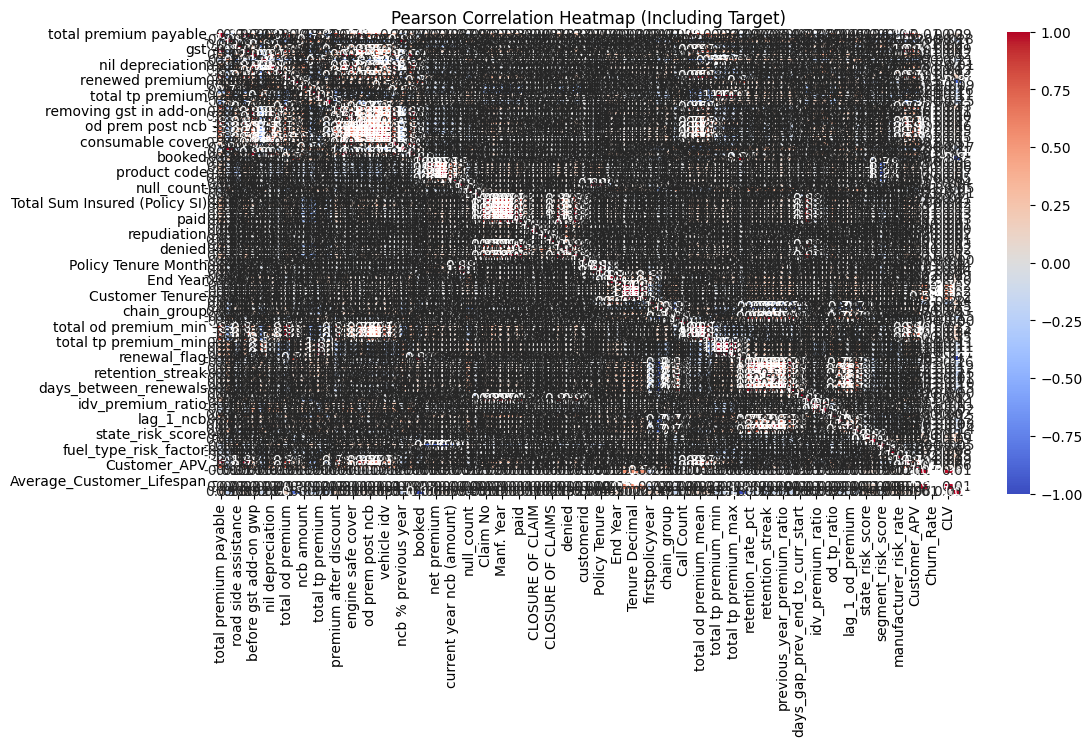

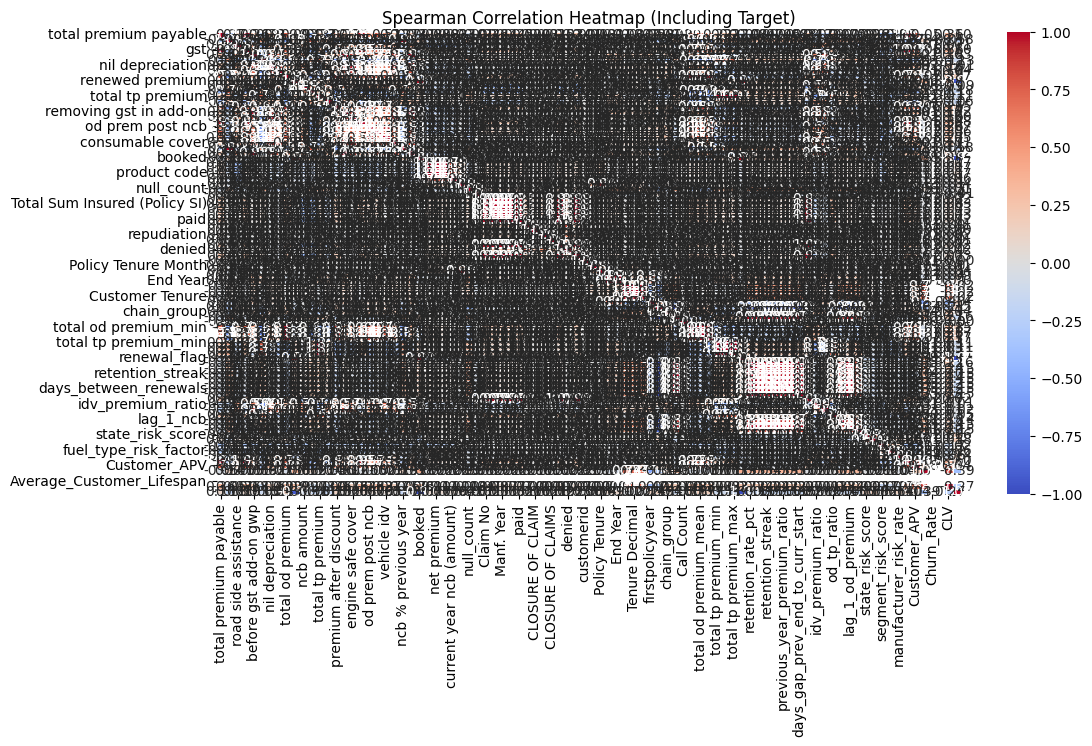


Highly Correlated Numerical Features (Pearson Correlation > 0.9):
gst <--> total premium payable | Correlation: 1.00
nil depreciation <--> before gst add-on gwp | Correlation: 0.92
premium after discount <--> total od premium | Correlation: 0.92
removing gst in add-on <--> before gst add-on gwp | Correlation: 0.99
removing gst in add-on <--> nil depreciation | Correlation: 0.94
engine safe cover <--> nil depreciation | Correlation: 0.94
engine safe cover <--> removing gst in add-on | Correlation: 0.91
premium before applicable tax <--> total premium payable | Correlation: 0.92
premium before applicable tax <--> gst | Correlation: 0.92
vehicle idv <--> od prem post ncb | Correlation: 0.95
consumable cover <--> nil depreciation | Correlation: 0.92
consumable cover <--> removing gst in add-on | Correlation: 0.90
consumable cover <--> engine safe cover | Correlation: 0.92
ncb % previous year <--> last year ncb | Correlation: 0.99
total add-on with gst <--> before gst add-on gwp | Correlat

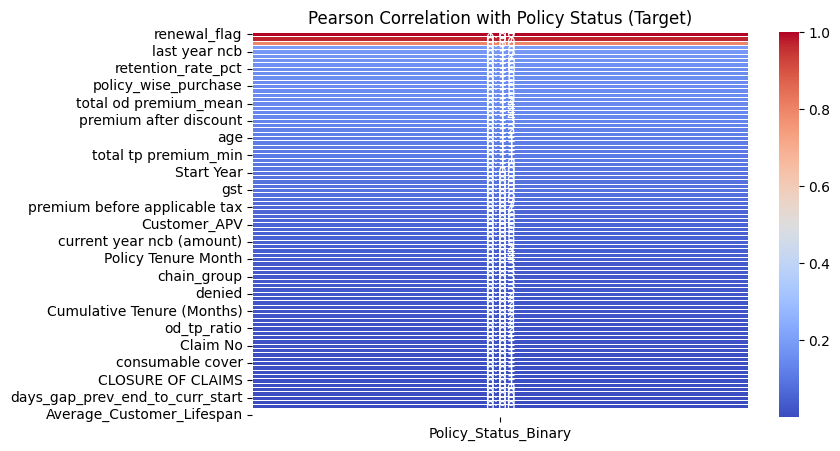

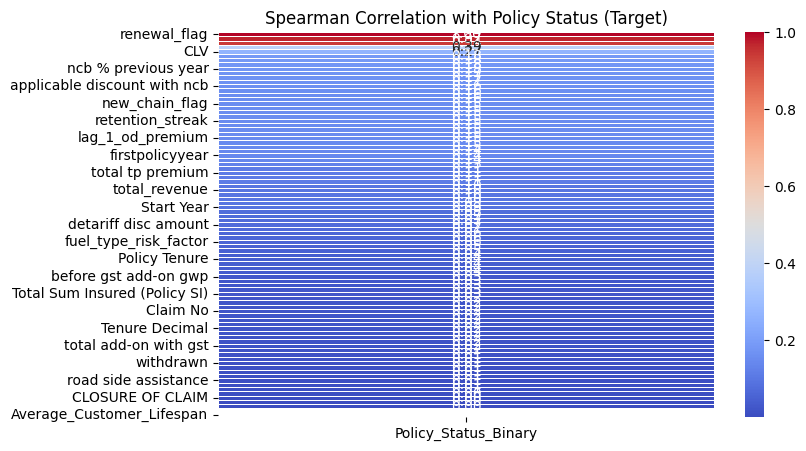

C:\Users\Admin\AppData\Local\Temp\ipykernel_33540\2993791574.py:107: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((r_corr-1), (k_corr-1)))



Cramér’s V (Strength of Association with Target):
policy no: Cramér’s V = 0.02524 (Weak)
premium payable without ncb: Cramér’s V = 0.16533 (Moderate)
add on eligibilty (5th & 6th renewals with ncb): Cramér’s V = 0.05963 (Weak)
product name: Cramér’s V = 0.18655 (Moderate)
biztype: Cramér’s V = 0.24307 (Moderate)
chassis number: Cramér’s V = 0.00000 (Weak)
product name 2: Cramér’s V = 0.13218 (Moderate)
oem discount category: Cramér’s V = 0.22559 (Moderate)
key loss: Cramér’s V = 0.06692 (Weak)
applicable discount without ncb: Cramér’s V = 0.16415 (Moderate)
state3: Cramér’s V = 0.17722 (Moderate)
oem category: Cramér’s V = 0.15583 (Moderate)
new vertical: Cramér’s V = 0.16049 (Moderate)
zone 2: Cramér’s V = 0.13574 (Moderate)
month: Cramér’s V = 0.18856 (Moderate)
enginenumber: Cramér’s V = 0.00000 (Weak)
policy number: Cramér’s V = 0.22086 (Moderate)
zone 3: Cramér’s V = 0.13574 (Moderate)
discount category with ncb: Cramér’s V = 0.17079 (Moderate)
decline: Cramér’s V = 0.10148 (Mode

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sqlalchemy import create_engine
import scipy.stats as stats

# Load Data from PostgreSQL
db_config = {
    'host': 'localhost',
    'database': 'Liberty',
    'user': 'postgres',
    'password': 'abc',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.policydata_with_fb_cc_pc_newfea_opti;'
df = pd.read_sql(query, con=engine)

# Separate categorical and numerical columns
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Fill missing values for numerical columns with 0
df[numerical_features] = df[numerical_features].fillna(0)

# Fill missing values for categorical columns with "Missing"
for col in categorical_features:
    df[col] = df[col].fillna("Missing")

df = df[df['Policy Status'].isin(['Renewed', 'Not Renewed'])]
df['Policy_Status_Binary'] = df['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

numerical_features.append("Policy_Status_Binary")  

# Compute Pearson correlation
pearson_corr = df[numerical_features].corr(method="pearson")

# Compute Spearman correlation
spearman_corr = df[numerical_features].corr(method="spearman")

plt.figure(figsize=(12, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap (Including Target)")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap (Including Target)")
plt.show()

# Identify Highly Correlated Features (Pearson > 0.9)
threshold = 0.9
high_corr_features = []

for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > threshold:
            high_corr_features.append((pearson_corr.columns[i], pearson_corr.columns[j], pearson_corr.iloc[i, j]))

# Print highly correlated numerical feature pairs (Pearson)
print("\nHighly Correlated Numerical Features (Pearson Correlation > 0.9):")
for feature1, feature2, corr_value in high_corr_features:
    print(f"{feature1} <--> {feature2} | Correlation: {corr_value:.2f}")
 
# Extract correlations with the target variable
target_corr_pearson = pearson_corr[["Policy_Status_Binary"]].drop("Policy_Status_Binary")
target_corr_spearman = spearman_corr[["Policy_Status_Binary"]].drop("Policy_Status_Binary")

# Sort by absolute correlation values
target_corr_pearson_sorted = target_corr_pearson.abs().sort_values(by="Policy_Status_Binary", ascending=False)
target_corr_spearman_sorted = target_corr_spearman.abs().sort_values(by="Policy_Status_Binary", ascending=False)

# Print correlation values with the target column
print("\nPearson Correlation of Numerical Features with Target (Policy Status Binary):")
print(target_corr_pearson_sorted)

print("\nSpearman Correlation of Numerical Features with Target (Policy Status Binary):")
print(target_corr_spearman_sorted)

# Visualize Correlation with Target
plt.figure(figsize=(8, 5))
sns.heatmap(target_corr_pearson_sorted, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation with Policy Status (Target)")
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(target_corr_spearman_sorted, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation with Policy Status (Target)")
plt.show()

# Compute Cramér’s V for Categorical Features
def cramers_v(x, y):
    """ Compute Cramér's V for association between two categorical variables """
    contingency_table = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((r_corr-1), (k_corr-1)))

cramers_v_results = {col: cramers_v(df[col], df["Policy_Status_Binary"]) for col in categorical_features}

# Print Cramér’s V results
print("\nCramér’s V (Strength of Association with Target):")
for col, v_value in cramers_v_results.items():
    strength = "Weak" if v_value < 0.1 else ("Moderate" if v_value < 0.3 else "Strong")
    print(f"{col}: Cramér’s V = {v_value:.5f} ({strength})")

# Remove High-Unique and Low-Variance Categorical Features
unique_counts = df[categorical_features].nunique()

# Remove high-cardinality features
high_unique_features = unique_counts[unique_counts > 50].index.tolist()
df_filtered = df.drop(columns=high_unique_features, errors="ignore")

# Remove low-variability features
low_variability_features = unique_counts[unique_counts == 1].index.tolist()
df_filtered = df_filtered.drop(columns=low_variability_features, errors="ignore")

# Remove features related to the target (data leakage)
features_to_remove = ["Policy_Status_Binary"]
df_filtered = df_filtered.drop(columns=features_to_remove, errors="ignore")

# Convert categorical features to numeric
df_encoded = df_filtered.copy()
for col in df_filtered.columns:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

# Perform Optimized Chi-Square Test
chi_square_results = []
for col in df_encoded.columns:
    contingency_table = pd.crosstab(df_encoded[col], df["Policy_Status_Binary"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append((col, p))

# Print Chi-Square Results
print("\nRefined Chi-Square Test Results:")
for col, p_val in chi_square_results:
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{col}: p-value = {p_val:.5f} ({significance})")

In [2]:
# Compute Optimized Information Value (IV)
def calculate_iv(df, feature, target):
    """Optimized IV Calculation using groupby"""
    total_renewed = df[df[target] == 1].shape[0]
    total_not_renewed = df[df[target] == 0].shape[0]

    grouped = df.groupby(feature)[target].agg(["count", "sum"])
    grouped.columns = ["count_total", "count_not_renewed"]

    grouped["count_renewed"] = grouped["count_total"] - grouped["count_not_renewed"]

    grouped["count_not_renewed"] = grouped["count_not_renewed"].replace(0, 0.5)
    grouped["count_renewed"] = grouped["count_renewed"].replace(0, 0.5)

    grouped["dist_not_renewed"] = grouped["count_not_renewed"] / total_not_renewed
    grouped["dist_renewed"] = grouped["count_renewed"] / total_renewed

    grouped["iv"] = (grouped["dist_renewed"] - grouped["dist_not_renewed"]) * np.log(grouped["dist_renewed"] / grouped["dist_not_renewed"])

    return grouped["iv"].sum()

iv_scores = {col: calculate_iv(df, col, "Policy_Status_Binary") for col in df.columns if col not in ["Policy_Status_Binary"]}

# Print IV Scores
print("\nInformation Value (IV) Scores:")
for col, iv_score in iv_scores.items():
    print(f"{col}: IV = {iv_score:.5f}")


Information Value (IV) Scores:
policy no: IV = 1.49772
premium payable without ncb: IV = 1.46940
add on eligibilty (5th & 6th renewals with ncb): IV = 1.21353
total premium payable: IV = 1.38915
product name: IV = 1.41357
last year ncb: IV = 1.37155
biztype: IV = 1.49122
road side assistance: IV = 1.21146
gst: IV = 1.28760
chassis number: IV = 1.47495
product name 2: IV = 1.30363
oem discount category: IV = 1.48118
key loss: IV = 1.21867
before gst add-on gwp: IV = 1.41875
age: IV = 1.57690
nil depreciation: IV = 1.39442
applicable discount without ncb: IV = 1.38956
state3: IV = 1.37897
passenger assist: IV = 1.21263
oem category: IV = 1.33628
total od premium: IV = 1.50285
new vertical: IV = 1.33025
renewed premium: IV = 9.22165
zone 2: IV = 1.30569
month: IV = 1.55049
enginenumber: IV = 1.47501
ncb amount: IV = 1.40452
renewal ncb: IV = 1.37176
total tp premium: IV = 1.33961
policy number: IV = 1.80257
policy end date: IV = 1.58904
applicable discount with ncb: IV = 1.43020
premium 

In [3]:
# Compute Optimized Information Value (IV) for Categorical Features Only
def calculate_iv(df, feature, target):
    """Optimized IV Calculation using groupby"""
    total_renewed = df[df[target] == 1].shape[0]
    total_not_renewed = df[df[target] == 0].shape[0]

    grouped = df.groupby(feature)[target].agg(["count", "sum"])
    grouped.columns = ["count_total", "count_not_renewed"]

    grouped["count_renewed"] = grouped["count_total"] - grouped["count_not_renewed"]

    grouped["count_not_renewed"] = grouped["count_not_renewed"].replace(0, 0.5)
    grouped["count_renewed"] = grouped["count_renewed"].replace(0, 0.5)

    grouped["dist_not_renewed"] = grouped["count_not_renewed"] / total_not_renewed
    grouped["dist_renewed"] = grouped["count_renewed"] / total_renewed

    grouped["iv"] = (grouped["dist_renewed"] - grouped["dist_not_renewed"]) * np.log(grouped["dist_renewed"] / grouped["dist_not_renewed"])

    return grouped["iv"].sum()

# Compute IV for categorical features only
iv_scores_categorical = {col: calculate_iv(df, col, "Policy_Status_Binary") for col in categorical_features if col in df.columns}

# Print IV Scores for Categorical Features
print("\nInformation Value (IV) Scores for Categorical Features:")
for col, iv_score in iv_scores_categorical.items():
    print(f"{col}: IV = {iv_score:.5f}")



Information Value (IV) Scores for Categorical Features:
policy no: IV = 1.49772
premium payable without ncb: IV = 1.46940
add on eligibilty (5th & 6th renewals with ncb): IV = 1.21353
product name: IV = 1.41357
biztype: IV = 1.49122
chassis number: IV = 1.47495
product name 2: IV = 1.30363
oem discount category: IV = 1.48118
key loss: IV = 1.21867
applicable discount without ncb: IV = 1.38956
state3: IV = 1.37897
oem category: IV = 1.33628
new vertical: IV = 1.33025
zone 2: IV = 1.30569
month: IV = 1.55049
enginenumber: IV = 1.47501
policy number: IV = 1.80257
zone 3: IV = 1.30569
discount category with ncb: IV = 1.34317
decline: IV = 1.29585
rto location: IV = 1.40817
renewal notice generation date: IV = 2.07221
new branch name: IV = 1.43885
reg year bucket 2: IV = 1.35131
renewal type: IV = 1.47049
state2: IV = 1.33567
tie up: IV = 1.52476
vehicle segment: IV = 1.25898
new branch name 2: IV = 1.37828
manufacturer/make: IV = 1.30812
model: IV = 1.39780
data: IV = 1.27856
insured name

In [4]:
from pathlib import Path

# 1. High correlation feature pairs (Pearson > 0.9)
high_corr_df = pd.DataFrame(
    high_corr_features,
    columns=["Feature_1", "Feature_2", "PearsonCorr"]
)

# 2. Cramér’s V values
cramers_v_df = pd.Series(cramers_v_results, name="CramersV").rename_axis("Feature").reset_index()

# 3. Chi-square p-values
chi_sq_df = pd.DataFrame(chi_square_results, columns=["Feature", "p_value"])
chi_sq_df["Significant"] = chi_sq_df["p_value"] < 0.05

# 4. IV scores (all features)
iv_all_df = pd.Series(iv_scores, name="IV").rename_axis("Feature").reset_index()

# 5. IV scores (categorical only)
iv_cat_df = pd.Series(iv_scores_categorical, name="IV").rename_axis("Feature").reset_index()

# 6. Combined Pearson + Spearman correlation with target
target_corr_combined = (
    target_corr_pearson.rename(columns={"Policy_Status_Binary": "Pearson"})
    .join(target_corr_spearman.rename(columns={"Policy_Status_Binary": "Spearman"}))
    .reset_index().rename(columns={"index": "Feature"})
)
target_corr_combined["Abs_Pearson"] = target_corr_combined["Pearson"].abs()
target_corr_combined["Abs_Spearman"] = target_corr_combined["Spearman"].abs()

# 7. Master feature score summary
num_scores = target_corr_combined[["Feature", "Pearson", "Spearman"]]
cat_scores = cramers_v_df
chi_scores = chi_sq_df[["Feature", "p_value"]]
iv_scores_df = iv_all_df

feature_scores = (
    num_scores
    .merge(cat_scores, on="Feature", how="outer")
    .merge(chi_scores, on="Feature", how="left")
    .merge(iv_scores_df, on="Feature", how="left")
    .sort_values(by=["Pearson", "Spearman"], key=lambda c: c.abs(), ascending=False)
)

# 8. Write all results to Excel
out_path = Path("feature_analysis_results.xlsx")
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    pearson_corr.to_excel(writer,               sheet_name="Pearson_Corr")
    spearman_corr.to_excel(writer,              sheet_name="Spearman_Corr")
    target_corr_pearson_sorted.to_excel(writer, sheet_name="TargetCorr_Pearson")
    target_corr_spearman_sorted.to_excel(writer, sheet_name="TargetCorr_Spearman")
    target_corr_combined.to_excel(writer,       sheet_name="Target_Corr_Combined", index=False)
    high_corr_df.to_excel(writer,               sheet_name="HighCorrPairs", index=False)
    cramers_v_df.to_excel(writer,               sheet_name="CramersV", index=False)
    chi_sq_df.to_excel(writer,                  sheet_name="ChiSquare", index=False)
    iv_all_df.to_excel(writer,                  sheet_name="IV_All", index=False)
    iv_cat_df.to_excel(writer,                  sheet_name="IV_Categorical", index=False)
    feature_scores.to_excel(writer,             sheet_name="Feature_Scores", index=False)

print(f" Excel summary saved to → {out_path.resolve()}")

 Excel summary saved to → D:\Liberty\New set of Features (Accuracy Improvement Task)\feature_analysis_results.xlsx


In [ ]:
pip install XlsxWriter

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sqlalchemy import create_engine
import scipy.stats as stats

# Load Data from PostgreSQL
db_config = {
    'host': 'localhost',
    'database': 'Liberty',
    'user': 'postgres',
    'password': 'abc',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.policydata_with_fb_cc_pc_newfea_opti;'
df = pd.read_sql(query, con=engine)

# Separate categorical and numerical columns
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Fill missing values for numerical columns with 0
df[numerical_features] = df[numerical_features].fillna(0)

# Fill missing values for categorical columns with "Missing"
for col in categorical_features:
    df[col] = df[col].fillna("Missing")

df = df[df['Policy Status'].isin(['Renewed', 'Not Renewed'])]
df['Policy_Status_Binary'] = df['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

numerical_features.append("Policy_Status_Binary") 

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Store target variable separately to prevent data leakage
y = df["Policy_Status_Binary"]

# Get unique value counts for categorical features
unique_counts = df[categorical_features].nunique()

# Remove high-cardinality features
high_unique_features = unique_counts[unique_counts > 50].index.tolist()
df_filtered = df.drop(columns=high_unique_features, errors="ignore")

# Remove low-variability features (features with only 1 unique value)
low_variability_features = unique_counts[unique_counts == 1].index.tolist()
df_filtered = df_filtered.drop(columns=low_variability_features, errors="ignore")

# Remove features known to cause data leakage
features_to_remove = ["Policy_Status_Binary"]
df_filtered = df_filtered.drop(columns=features_to_remove, errors="ignore")

# Convert categorical features to numeric
df_encoded = df_filtered.apply(lambda col: col.astype("category").cat.codes)

# Perform Chi-Square Test
chi_square_results = []
for col in df_encoded.columns:
    contingency_table = pd.crosstab(df_encoded[col], y)  
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi_square_results.append((col, p))

# Print results
print("\nRefined Chi-Square Test Results:")
for col, p_val in chi_square_results:
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{col}: p-value = {p_val:.5f} ({significance})")

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Store target variable separately to prevent data leakage
y = df["Policy_Status_Binary"]

# Get unique value counts for categorical features
unique_counts = df[categorical_features].nunique()

# Remove high-cardinality features
high_unique_features = unique_counts[unique_counts > 30].index.tolist()
df_filtered = df.drop(columns=high_unique_features, errors="ignore")

# Remove low-variability features (features with only 1 unique value)
low_variability_features = unique_counts[unique_counts == 1].index.tolist()
df_filtered = df_filtered.drop(columns=low_variability_features, errors="ignore")

# Remove features known to cause data leakage
features_to_remove = ["Policy_Status_Binary"]
df_filtered = df_filtered.drop(columns=features_to_remove, errors="ignore")

# Convert categorical features to numeric
df_encoded = df_filtered.apply(lambda col: col.astype("category").cat.codes)

# Perform Chi-Square Test
chi_square_results = []
for col in df_encoded.columns:
    contingency_table = pd.crosstab(df_encoded[col], y)
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi_square_results.append((col, p))

# Print results
print("\nRefined Chi-Square Test Results:")
for col, p_val in chi_square_results:
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{col}: p-value = {p_val:.5f} ({significance})")